percobaan ke 2. dari prediksi gas. masih belum akurat

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [2]:
# Membaca semua dataset
data_paths = [
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_1.csv",
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_9.csv",
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_20.csv",
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_21.csv",
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_23.csv",
    r"C:\Users\HP\Documents\data mining\uts-uas\train\ex_24.csv"
]

In [3]:
# Membaca dan menggabungkan dataset
datasets = []
for path in data_paths:
    df = pd.read_csv(path)
    df = df[['time', 'input_voltage', 'el_power']]
    datasets.append(df)

In [4]:
# Menggabungkan semua dataset
train_data = pd.concat(datasets, ignore_index=True)

In [5]:
# Data Preprocessing
# Scalers
voltage_scaler = RobustScaler()
power_scaler = RobustScaler()

In [6]:
# Normalisasi
train_data['input_voltage_scaled'] = voltage_scaler.fit_transform(train_data[['input_voltage']])
train_data['el_power_scaled'] = power_scaler.fit_transform(train_data[['el_power']])

In [7]:
# Fitur waktu
train_data['hour'] = pd.to_datetime(train_data['time']).dt.hour
train_data['day'] = pd.to_datetime(train_data['time']).dt.day
train_data['month'] = pd.to_datetime(train_data['time']).dt.month

In [8]:
# Fitur teknikal
train_data['voltage_rolling_mean'] = train_data['input_voltage'].rolling(window=24).mean()
train_data['power_rolling_mean'] = train_data['el_power'].rolling(window=24).mean()
train_data['voltage_rolling_std'] = train_data['input_voltage'].rolling(window=24).std()
train_data['power_rolling_std'] = train_data['el_power'].rolling(window=24).std()

In [9]:
# Handle NaN values dari rolling calculations
train_data = train_data.fillna(method='bfill')

C:\Users\HP\AppData\Local\Temp\ipykernel_1124\2286260598.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='bfill')


In [10]:
# Define features untuk model
features_used = ['input_voltage_scaled', 'el_power_scaled', 
                'hour', 'day', 'month',
                'voltage_rolling_mean', 'power_rolling_mean',
                'voltage_rolling_std', 'power_rolling_std']

In [11]:
# Prepare features untuk model
X = train_data[features_used].values
n_features = len(features_used)

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [12]:
# Membuat sequence data
seq_length = 20
X_train, y_train = create_sequences(X, seq_length)
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

Shape X_train: (52920, 20, 9)
Shape y_train: (52920, 9)


In [13]:
# Model Definition
def create_model(n_features, seq_length):
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', return_sequences=True), 
                     input_shape=(seq_length, n_features)),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        
        Bidirectional(LSTM(32, activation='relu')),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(n_features)
    ])
    return model

In [14]:
# Learning Rate Schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

In [15]:
# Callbacks
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
#     ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
#     LearningRateScheduler(lr_schedule)
# ]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),  # ubah .h5 ke .keras
    LearningRateScheduler(lr_schedule)
]


In [16]:
# Model Compilation
model = create_model(n_features, seq_length)

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, 
             loss='huber',
             metrics=['mae', 'mse'])

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Cross Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
histories = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f'Fold {fold+1}/{n_splits}')
    
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    histories.append(history)


Fold 1/5
Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 73s 148ms/step - loss: 260.5492 - mae: 260.9435 - mse: 703180.8750 - val_loss: 172.1986 - val_mae: 172.4421 - val_mse: 260403.3750 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - loss: 259.5017 - mae: 259.7487 - mse: 703406.6250 - val_loss: 170.7831 - val_mae: 171.0585 - val_mse: 258292.4219 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 42s 144ms/step - loss: 257.9465 - mae: 258.1569 - mse: 699217.9375 - val_loss: 265.1401 - val_mae: 265.6208 - val_mse: 239924.8125 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - loss: 253.2513 - mae: 253.4536 - mse: 680890.1250 - val_loss: 166.2622 - val_mae: 166.4772 - val_mse: 247684.9375 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - loss: 254.1702 - mae: 254.3690 - mse: 683539.0625 - val_loss: 161.0579 - val_mae: 161.3119 - val_mse: 234667.6562 - learning_rate: 0.0010
Epoch 6/100

In [18]:
# Visualisasi hasil training
def visualize_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot training dan validation loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    
    # Mendapatkan nilai loss terbaik
    min_train_loss = min(history.history['loss'])
    min_val_loss = min(history.history['val_loss'])
    min_train_epoch = np.argmin(history.history['loss'])
    min_val_epoch = np.argmin(history.history['val_loss'])
    
    # Menambahkan anotasi untuk training loss terbaik
    plt.annotate(f'Best Training Loss: {min_train_loss:.6f}', 
                xy=(min_train_epoch, min_train_loss),
                xytext=(min_train_epoch + 5, min_train_loss * 1.2),
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
    
    # Menambahkan anotasi untuk validation loss terbaik
    plt.annotate(f'Best Validation Loss: {min_val_loss:.6f}', 
                xy=(min_val_epoch, min_val_loss),
                xytext=(min_val_epoch + 5, min_val_loss * 0.8),
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'))
    
    plt.title('Model Loss over Time', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    return min_train_loss, min_val_loss, min_train_epoch, min_val_epoch

In [19]:
# Hyperparameter Tuning
def build_model(hp):
    model = Sequential()
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            activation='relu',
            return_sequences=True if i < hp.Int('num_layers', 1, 4)-1 else False
        )))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))
    
    model.add(Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(n_features))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='huber'
    )
    return model

In [20]:
# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='power_prediction'
)

tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=5)])


Trial 10 Complete [01h 17m 39s]
val_loss: 23.028587341308594

Best val_loss So Far: 2.9980645179748535
Total elapsed time: 12h 22m 14s


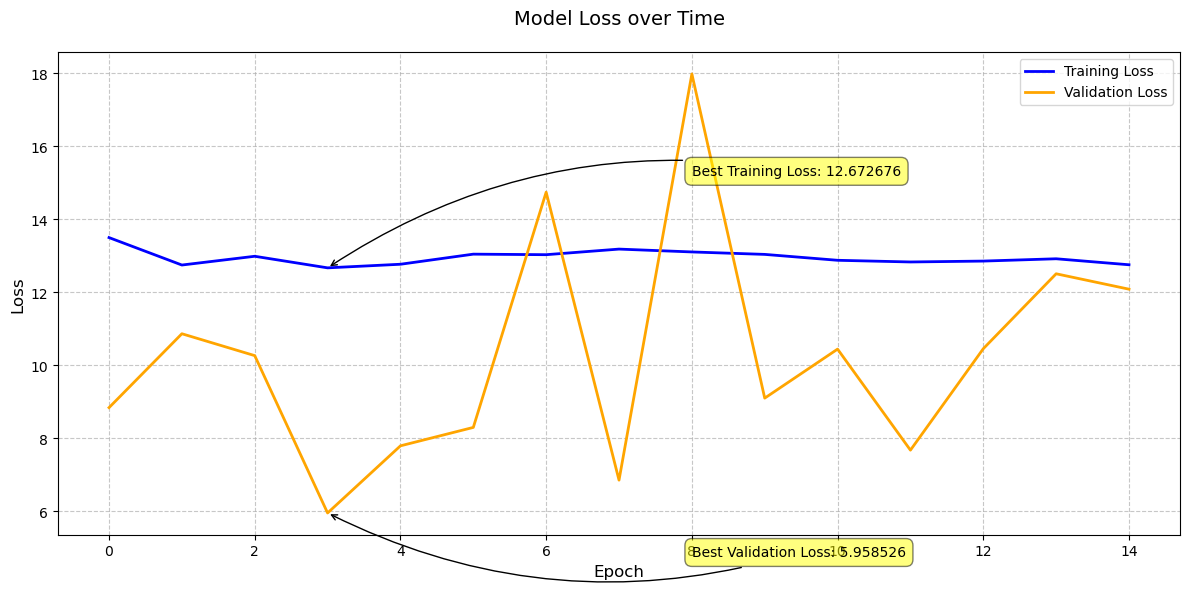

In [21]:
# Visualisasi hasil dan evaluasi untuk fold terakhir
min_train_loss, min_val_loss, min_train_epoch, min_val_epoch = visualize_training_history(history)


In [23]:
# Evaluasi prediksi
print("\nEvaluasi Sample Prediksi:")
test_samples = X_train[:5]
predictions = model.predict(test_samples)


Evaluasi Sample Prediksi:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [24]:
# Tampilkan hasil dalam format tabel
print("\nPerbandingan Prediksi vs Aktual:")
print("--------------------------------")
print("Sample | Prediksi (V, P) | Aktual (V, P) | Error (%)")
print("--------------------------------")
for i in range(len(predictions)):
    pred_v, pred_p = predictions[i][0], predictions[i][1]  # Mengambil voltage dan power dari prediksi
    act_v, act_p = y_train[i][0], y_train[i][1]  # Mengambil voltage dan power dari aktual
    error_v = abs((pred_v - act_v) / act_v * 100)
    error_p = abs((pred_p - act_p) / act_p * 100)
    print(f"{i+1:6d} | ({pred_v:.2f}, {pred_p:.2f}) | ({act_v:.2f}, {act_p:.2f}) | ({error_v:.2f}%, {error_p:.2f}%)")



Perbandingan Prediksi vs Aktual:
--------------------------------
Sample | Prediksi (V, P) | Aktual (V, P) | Error (%)
--------------------------------
     1 | (-0.22, -0.44) | (1.17, -0.24) | (118.75%, 84.75%)
     2 | (-0.22, -0.44) | (1.17, -0.25) | (118.74%, 74.09%)
     3 | (-0.22, -0.44) | (1.17, -0.23) | (118.73%, 96.63%)
     4 | (-0.22, -0.44) | (1.17, -0.24) | (118.72%, 86.20%)
     5 | (-0.22, -0.44) | (1.17, -0.24) | (118.71%, 87.46%)


In [25]:
# Hitung dan tampilkan statistik error
mse = np.mean((predictions - y_train[:len(predictions)]) ** 2)
mae = np.mean(np.abs(predictions - y_train[:len(predictions)]))
mape = np.mean(np.abs((y_train[:len(predictions)] - predictions) / y_train[:len(predictions)])) * 100

print("\nMetrik Evaluasi:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Metrik Evaluasi:
Mean Squared Error (MSE): 84.469967
Mean Absolute Error (MAE): 4.785817
Mean Absolute Percentage Error (MAPE): inf%


C:\Users\HP\AppData\Local\Temp\ipykernel_1124\1638393645.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_train[:len(predictions)] - predictions) / y_train[:len(predictions)])) * 100
